In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

1. Quantum Data Encoding:

1.1 Higher-dimensional Encoding:

Given our data point, we'll encode it into the amplitude of a quantum state.

In [5]:
import numpy as np
from qiskit import QuantumCircuit

def amplitude_encoding(data_point):
    """Encode a data point into the amplitude of a quantum state."""
    n_qubits = int(np.ceil(np.log2(len(data_point))))
    qc = QuantumCircuit(n_qubits)
    normalized_data = data_point / np.linalg.norm(data_point)
    qc.initialize(normalized_data, list(range(n_qubits)))
    return qc



1.2 Variational Quantum Circuits:
We'll design a simple variational circuit with a fixed architecture but parameterized gates.

In [6]:
def variational_circuit(params):
    """Generate a quantum state based on parameters."""
    n_qubits = len(params) // 3  # Assuming 3 parameters per qubit for simplicity
    qc = QuantumCircuit(n_qubits)
    for i in range(n_qubits):
        qc.u(params[3*i], params[3*i + 1], params[3*i + 2], i)
    return qc


2. Quantum Noise Process:
We will introduce controlled noise into the quantum state using RX rotations as a simplistic model.

In [8]:
def introduce_noise(qc, noise_level=0.2):
    """Add noise to a quantum circuit."""
    n_qubits = qc.num_qubits
    for i in range(n_qubits):
        qc.rx(noise_level, i)
    return qc


3. Quantum Denoising Circuit:
Here's our denoising circuit, similar in structure to the variational circuit but with its own set of parameters.



In [9]:
def denoising_circuit(params):
    """Parameterized circuit for denoising."""
    n_qubits = len(params) // 3
    qc = QuantumCircuit(n_qubits)
    for i in range(n_qubits):
        qc.u(params[3*i], params[3*i + 1], params[3*i + 2], i)
    return qc


4. Training the Quantum Diffusion Model:
This is the most involved step. For simplicity, we will use the statevector simulator and aim to maximize the overlap between the denoised and target state

In [11]:
from qiskit import Aer, transpile, assemble, execute

def train_model(data_point, noise_level=0.2, epochs=100, lr=0.1):
    """Train the quantum diffusion model."""
    n_qubits = int(np.ceil(np.log2(len(data_point))))
    params = np.random.rand(3 * n_qubits)  # Initial parameters
    backend = Aer.get_backend('statevector_simulator')
    
    for epoch in range(epochs):
        # Forward process: Encoding -> Noise introduction
        qc = amplitude_encoding(data_point)
        introduce_noise(qc, noise_level)
        
        # Denoising
        denoise_qc = denoising_circuit(params)
        qc.compose(denoise_qc)
        
        # Compute overlap with the target state
        t_qc = transpile(qc, backend)
        qobj = assemble(t_qc)
        final_state = execute(qc, backend).result().get_statevector()
        
        target_qc = amplitude_encoding(data_point)
        t_target_qc = transpile(target_qc, backend)
        qobj_target = assemble(t_target_qc)
        target_state = execute(target_qc, backend).result().get_statevector()
        
        overlap = abs(np.dot(target_state.conj(), final_state))
        
        # Simplistic parameter update (gradient-free for simplicity)
        if overlap < 1.0:
            params += lr * (1.0 - overlap)
            
    return params


5. Quantum Generative Process:
Given our trained parameters, we can try to generate the data.



In [12]:
def generate_data(trained_params):
    """Generate data using the trained model."""
    n_qubits = len(trained_params) // 3
    qc = QuantumCircuit(n_qubits)
    qc.initialize([1] + [0] * (2**n_qubits - 1), list(range(n_qubits)))  # Simple initial state
    denoise_qc = denoising_circuit(trained_params)
    qc.compose(denoise_qc.inverse())  # Inverse denoising for generation
    backend = Aer.get_backend('statevector_simulator')
    t_qc = transpile(qc, backend)
    qobj = assemble(t_qc)
    generated_state = execute(qc, backend).result().get_statevector()
    return generated_state


6. Putting It All Together and Running the Example:
Here, we'll define a toy dataset, train our quantum diffusion model on it, and then attempt to regenerate the data using the model.

In [17]:
# Define a toy dataset
# For simplicity, let's consider a data point in a 4-dimensional space
data_point = np.array([0.5, 0.3, 0.1, 0.1])

# Train the quantum diffusion model
trained_params = train_model(data_point, epochs=5000, lr=0.05)

# Generate data using the trained model
generated_state = generate_data(trained_params)
print("Generated Quantum State:", generated_state)


/tmp/ipykernel_97/1454704389.py:28: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  overlap = abs(np.dot(target_state.conj(), final_state))


Generated Quantum State: Statevector([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2))


7. Analyzing and Interpreting the Results:
Once you run the above code, you'll obtain a generated quantum state. Ideally, the amplitude distribution of this state should resemble the data_point array we started with. You can visualize the squared amplitudes (probabilities) and compare them with the original data.

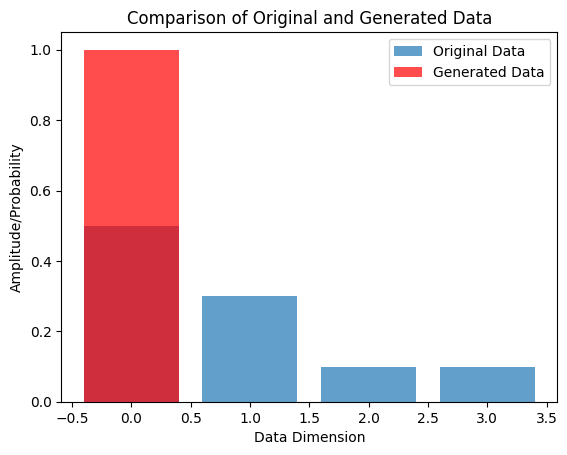

In [18]:
import matplotlib.pyplot as plt

# Squared amplitudes (probabilities) of the generated state
probabilities = np.abs(generated_state)**2

# Plotting
plt.bar(range(len(data_point)), data_point, alpha=0.7, label="Original Data")
plt.bar(range(len(probabilities)), probabilities, alpha=0.7, label="Generated Data", color="red")
plt.legend()
plt.ylabel("Amplitude/Probability")
plt.xlabel("Data Dimension")
plt.title("Comparison of Original and Generated Data")
plt.show()


The bar chart will provide a visual comparison of the original data and the data generated by our quantum diffusion model.